In [5]:
import layoutparser as lp
import cv2

In [6]:
import os
import numpy as np

In [330]:
import torch.nn as nn
import torchvision.transforms as transforms
from matplotlib import pyplot as plt

In [7]:
model_HJDataset = lp.Detectron2LayoutModel(
    config_path ='lp://HJDataset/mask_rcnn_R_50_FPN_3x/config', # In model catalog
    label_map   = {1:"Page Frame", 2:"Row", 3:"Title Region", 4:"Text Region", 5:"Title", 6:"Subtitle", 7:"Other"}, # In model`label_map`
)

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [8]:
model_PubLayNet = lp.Detectron2LayoutModel(
    config_path ='lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config', # In model catalog
    label_map   = {0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"}, # In model`label_map`
)

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [9]:
model_PrimaLayout = lp.Detectron2LayoutModel(
    config_path ='lp://PrimaLayout/mask_rcnn_R_50_FPN_3x/config', # In model catalog
    label_map   = {1:"TextRegion", 2:"ImageRegion", 3:"TableRegion", 4:"MathsRegion", 5:"SeparatorRegion", 6:"OtherRegion"}, # In model`label_map`
)

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [10]:
model_NewspaperNavigator = lp.Detectron2LayoutModel(
    config_path ='lp://NewspaperNavigator/faster_rcnn_R_50_FPN_3x/config', # In model catalog
    label_map   = {0: "Photograph", 1: "Illustration", 2: "Map", 3: "Comics/Cartoon", 4: "Editorial Cartoon", 5: "Headline", 6: "Advertisement"}, # In model`label_map`
)

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [11]:
models = [(model_HJDataset, 'HJDataset'), (model_PubLayNet, 'PubLayNet'), (model_PrimaLayout, 'PrimalLayout'),  (model_NewspaperNavigator, 'NewspaperNavigator')]

In [336]:
from dataclass import image_dataset_train
from utils import label2id, id2label

In [131]:
def select_images_from_category(dataset, category):
    selected_images = [image for image, label in dataset if label == category]
    return selected_images

In [132]:
import random

def select_random_image_from_category(dataset, category):
    selected_images = [image for image, label in dataset if label == category]
    if not selected_images:
        return None  # zwraca None, jeśli nie ma żadnego obrazu z tej kategorii
    return random.choice(selected_images)

In [ ]:
def select_one_image_from_category(dataset, category):
    for image, label in dataset:
        if label == category:
            return image


In [331]:
type(image_dataset_train)

dataclass.ImageDataSet

In [391]:
import torch
from torchvision import transforms
from PIL import Image

class LayoutParserTransform:
    def __init__(self, model):
        self.model = model
        self.pooling_layer = nn.AvgPool2d(kernel_size=8, stride=8)

    def __call__(self, sample):
        image, label = sample[0], sample[1]

        # Użyj modelu do wykrycia layoutu
        layout = self.model.detect(image)

        # Stwórz puste tło
        blank_image = np.zeros_like(image)

        # Narysuj bounding boxy
        image_with_boxes_only = lp.draw_box(blank_image, layout, box_width=3)

        # Przekonwertuj na skalę szarości
        image_with_boxes_only_np = np.array(image_with_boxes_only).astype('uint8')
        image_with_boxes_only_gray = cv2.cvtColor(image_with_boxes_only_np, cv2.COLOR_BGR2GRAY)

        # Przekształć obraz ndarray do tensora
        image_with_boxes_only_gray = torch.from_numpy(image_with_boxes_only_gray)

        # Dodaj dodatkowy wymiar dla kanałów
        image_with_boxes_only_gray = image_with_boxes_only_gray.unsqueeze(0)

        # Wykonanie operacji pooling
        image_pooled = self.pooling_layer(image_with_boxes_only_gray.float())

        # Usuń niepotrzebne wymiary
        image_pooled = torch.squeeze(image_pooled)

        return (image_pooled, label)

class ResizeWithPad:
    def __init__(self, size):
        self.size = size

    def __call__(self, sample):
        image, label = sample[0], sample[1]

        # Obliczamy różnicę między rozmiarem docelowym a rzeczywistym rozmiarem obrazka
        diff = self.size - min(image.shape[0], image.shape[1])

        # Dokonujemy paddingu tylko wtedy, gdy jest to konieczne
        if diff > 0:
            padding = diff // 2
            image = cv2.copyMakeBorder(image, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=0)

        # Skalujemy obraz do rozmiaru docelowego
        image = cv2.resize(image, (self.size, self.size))

        return (image, label)

In [392]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]

        # Przekonwertuj obrazek na PIL Image jeżeli jest w formacie NumPy array
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, label

In [393]:
resize_with_pad = ResizeWithPad(size=800)
layout_parser_transform = LayoutParserTransform(model=model_PrimaLayout)

# Teraz zaaplikuj te transformacje na danych
transformed_dataset_train = CustomDataset(image_dataset_train, transform=transforms.Compose([
    resize_with_pad, layout_parser_transform
]))

In [394]:
first_image, first_label = transformed_dataset_train[0]

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)


/var/folders/75/h732df2s1db24jq2ltzxj9lw0000gn/T/ipykernel_85051/1877918249.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  image = torch.tensor([sample])


AttributeError: 'Tensor' object has no attribute 'strides'

In [279]:
image = image_dataset_train[6667][0]

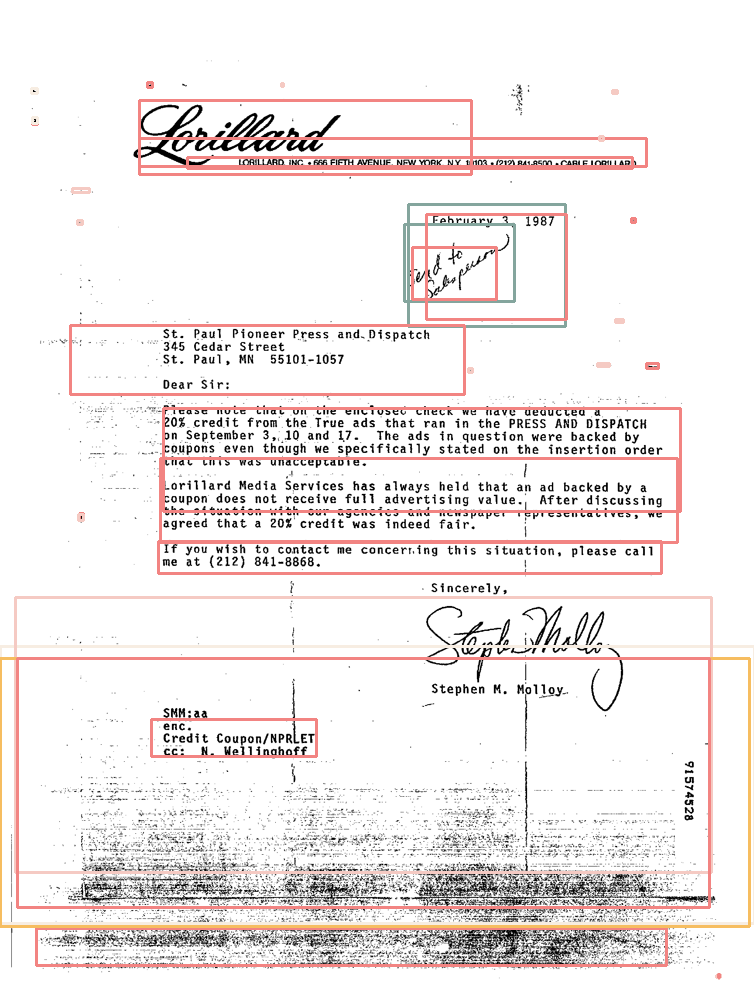

In [325]:
image = image_dataset_train[2693][0]

# Przekształcenie obrazu w skali szarości na obraz 3-kanałowy
if len(image.shape) == 2:
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

# Przekształcenie obrazu BGR na obraz RGB
elif len(image.shape) == 3:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

layout = model_PrimaLayout.detect(image)
lp.draw_box(image, layout, box_width=3)

In [309]:
layout[0]

TextBlock(block=Rectangle(x_1=161.52967834472656, y_1=208.7163848876953, x_2=201.08993530273438, y_2=217.0399627685547), text=None, id=None, type=TextRegion, parent=None, next=None, score=0.9995632767677307)

In [326]:
# Inicjalizacja pustego obrazu o wymiarach oryginalnego obrazu
blank_image = np.zeros_like(image)

# Rysowanie ramek na pustym obrazie
image_with_boxes_only = lp.draw_box(blank_image, layout, box_width=3)
# Przekonwertuj obraz PIL na array NumPy
image_with_boxes_only_np = np.array(image_with_boxes_only)

# Przekonwertuj obraz na 8-bitowe liczby całkowite
image_with_boxes_only_np = image_with_boxes_only_np.astype('uint8')

image_with_boxes_only_gray = cv2.cvtColor(image_with_boxes_only_np, cv2.COLOR_BGR2GRAY)
image_with_boxes_only_gray

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

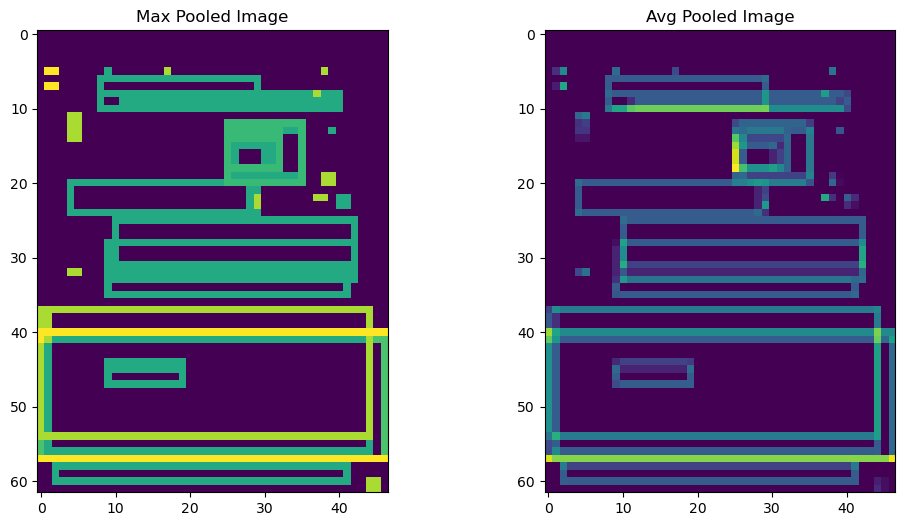

In [327]:
# Załadowanie obrazu i konwersja na tensor
transform = transforms.ToTensor()
image = image_with_boxes_only_gray  # Wpisz tutaj ścieżkę do obrazu
image = transform(image)
image = image.unsqueeze(0)  # Dodaj dodatkowy wymiar dla batch size

# Definiowanie warstwy pooling
max_pooling_layer = nn.MaxPool2d(kernel_size=16, stride=16)
avg_pooling_layer = nn.AvgPool2d(kernel_size=16, stride=16)

# Wykonanie operacji pooling
image_max_pooled = max_pooling_layer(image)
image_avg_pooled = avg_pooling_layer(image)

# Usuwanie dodatkowego wymiaru batch size i konwersja z powrotem na obraz
image_max_pooled = image_max_pooled.squeeze(0).permute(1, 2, 0).numpy()
image_avg_pooled = image_avg_pooled.squeeze(0).permute(1, 2, 0).numpy()

# Wyświetlanie zmniejszonych obrazów
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image_max_pooled)
plt.title("Max Pooled Image")

plt.subplot(1, 2, 2)
plt.imshow(image_avg_pooled)
plt.title("Avg Pooled Image")

plt.show()

In [258]:

# Określ docelowy rozmiar - 10% oryginalnego rozmiaru
new_size = (int(image_with_boxes_only_gray.shape[1]*0.1), int(image_with_boxes_only_gray.shape[0]*0.1))

# Skalowanie obrazu
resized_image = cv2.resize(image_with_boxes_only_gray, new_size, interpolation = cv2.INTER_AREA)

# Wybierz rozmiar okna dla operacji max pooling
pool_size = (2, 2)

# Przeprowadź operację max pooling
pooled_image = np.mean(resized_image, pool_size, np.max)

# Wyświetlanie wyników
plt.figure(figsize=(10, 10))
plt.imshow(pooled_image, cmap='gray')
plt.title('Pooled image')
plt.show()


AxisError: axis 2 is out of bounds for array of dimension 2

In [332]:
image_max_pooled.shape

(62, 47, 1)

In [116]:
def count_labels(image_dataset):
    label_counts = {}
    for _, label in image_dataset:
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1
    return label_counts

In [117]:
train_labels_counted = count_labels(image_dataset_train)

In [118]:
for i in range(21):
    print (f'Klasa {i} ({label2id[i]}) zawiera {train_labels_counted[i]} elementów.')

Klasa 0 (advertisement) zawiera 580 elementów.
Klasa 1 (budget) zawiera 556 elementów.
Klasa 2 (email) zawiera 563 elementów.
Klasa 3 (file_folder) zawiera 566 elementów.
Klasa 4 (form) zawiera 566 elementów.
Klasa 5 (handwritten) zawiera 618 elementów.
Klasa 6 (invoice) zawiera 555 elementów.
Klasa 7 (letter) zawiera 551 elementów.
Klasa 8 (memo) zawiera 558 elementów.
Klasa 9 (news_article) zawiera 503 elementów.
Klasa 10 (pit37_v1) zawiera 400 elementów.
Klasa 11 (pozwolenie_uzytkowanie_obiektu_budowlanego) zawiera 295 elementów.
Klasa 12 (presentation) zawiera 592 elementów.
Klasa 13 (questionnaire) zawiera 551 elementów.
Klasa 14 (resume) zawiera 565 elementów.
Klasa 15 (scientific_publication) zawiera 577 elementów.
Klasa 16 (scientific_report) zawiera 584 elementów.
Klasa 17 (specification) zawiera 529 elementów.
Klasa 18 (umowa_na_odleglosc_odstapienie) zawiera 390 elementów.
Klasa 19 (umowa_o_dzielo) zawiera 373 elementów.
Klasa 20 (umowa_sprzedazy_samochodu) zawiera 377 eleme

In [51]:
en_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17]
pl_labels = [11, 18, 19, 20]

In [156]:
image = select_random_image_from_category(dataset=image_dataset_train, category=0)

In [157]:
# Przekształcenie obrazu w skali szarości na obraz 3-kanałowy
if len(image.shape) == 2:
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

# Przekształcenie obrazu BGR na obraz RGB
elif len(image.shape) == 3:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

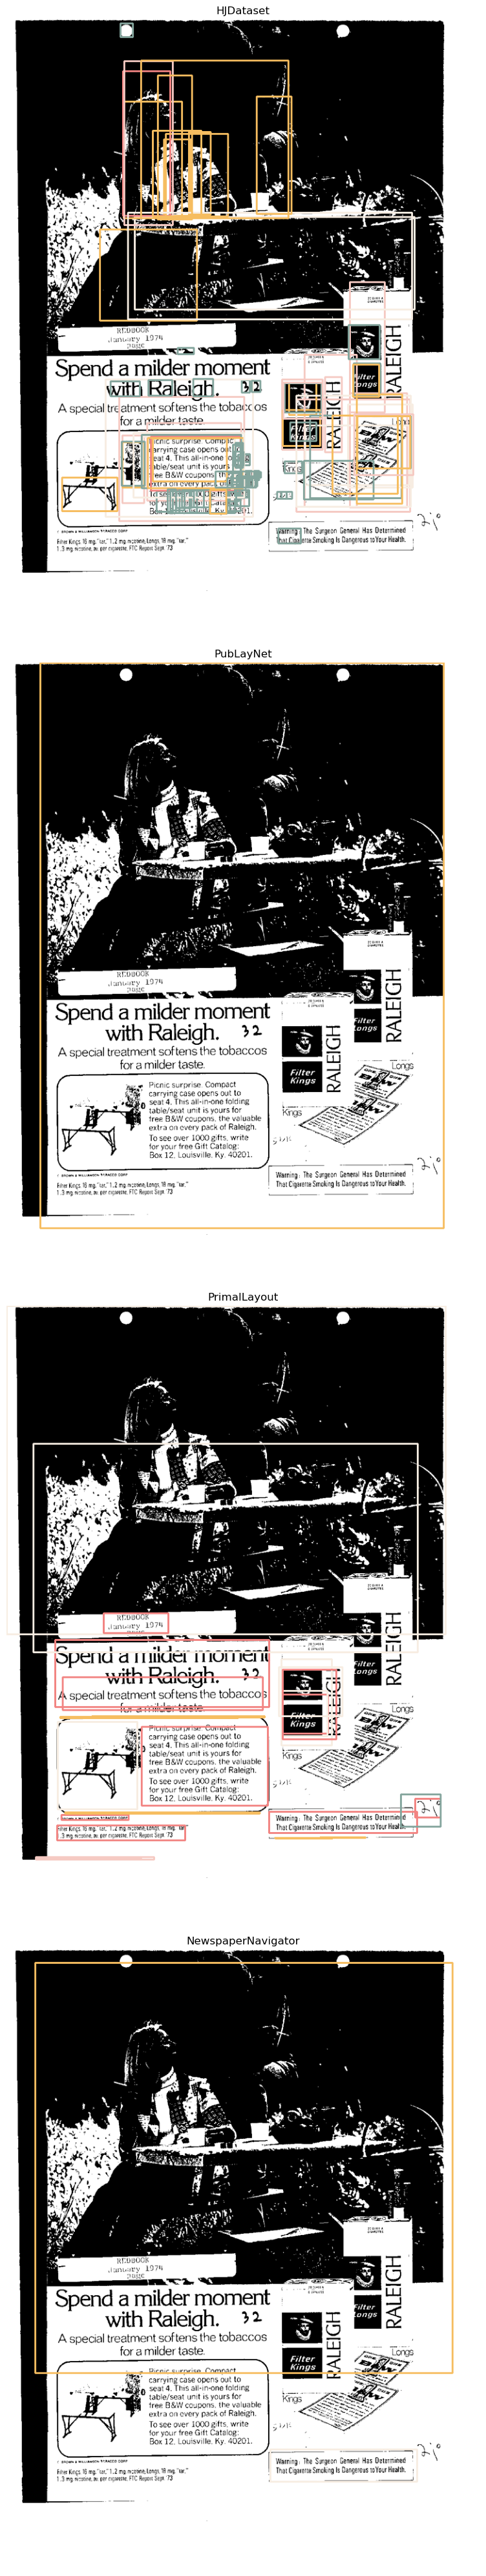

In [158]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(models), 1, figsize=(10, 10 * len(models)))

for ax, (model, model_name) in zip(axs, models):
    layout = model.detect(image)
    image_with_boxes = lp.draw_box(image, layout, box_width=3)

    ax.imshow(image_with_boxes)
    ax.axis('off')  # ukrywa osie
    ax.set_title(model_name)

plt.tight_layout()
plt.show()